<a href="https://colab.research.google.com/github/sraviauniverse/T-systems-Vinsys-Evaluation-Labs/blob/main/Lab_2_Evaluating_Embedding_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 2 — Evaluating Embedding Models (Cosine Similarity & Top-K Retrieval)

**Duration:** ~2 hours  
**GPU:** Optional (T4 allowed; CPU is fine)  
**Goal:** Learn how to **create**, **use**, and **evaluate** text embeddings for information retrieval (IR), and build a small, reproducible harness you can reuse in real projects.

---

## Why this lab
Modern search, RAG, deduplication, and clustering all rely on **embeddings**—vectors that position semantically similar texts close together. Good systems aren’t just about picking a model; they require **consistent preprocessing, fair evaluation, and thoughtful operating-point choices**. This lab focuses on practical, end-to-end evaluation that you can rerun with different models or datasets.

---

## Learning outcomes
By the end, you will be able to:
- Explain what an **embedding** is and why **cosine similarity** is a strong default.
- Implement **Top-K retrieval** with normalized vectors and understand how **K** affects precision vs recall.
- Compute and interpret IR metrics: **Precision@K**, **Recall@K**, **MRR@K**, **nDCG@K**.
- Compare multiple model families fairly (MiniLM, E5, BGE, **optional Azure OpenAI**) with **prefix-aware formatting**.
- Perform **qualitative inspection** of nearest neighbors to sanity-check metric conclusions.
- Try simple **score fusion** and understand when/why it helps.
- Tie quality to **latency/cost** by timing encoders.

---

## What you will build
1. A small, multi-topic **query ↔ document** dataset (tech, health, travel, …).
2. A **model-agnostic evaluation harness**:
   - Normalized embeddings + cosine similarity.
   - Top-K ranking for each query.
   - Metric suite (**P@K**, **R@K**, **MRR**, **nDCG**) at multiple K values.
3. A **comparison dashboard** (tables + plots) across models.
4. (Stretch) A **fusion** baseline (simple average of normalized scores) and a timing plot.

---


## Models we’ll compare (and why)
- **MiniLM (`all-MiniLM-L6-v2`)** — strong general-purpose baseline; compact and fast.
- **E5 (`e5-small-v2`)** — expects **`query:`**/**`passage:`** prefixes; optimized for retrieval tasks.
- **BGE (`bge-small-en-v1.5`)** — also benefits from **`query:`**/**`passage:`** prompting.
- **Azure OpenAI (optional)** — compare your organization’s **hosted embeddings** (e.g., `text-embedding-3-small/large`) side-by-side.

> **Important:** Prompt formatting can significantly impact quality. We evaluate models with their **recommended prefixes** to keep the comparison fair.

---

## Evaluation philosophy used here
- **Normalize embeddings** before scoring (cosine). Avoids norm inflation and stabilizes cross-model comparisons.
- **Multiple K values** (1/3/5/10). Different tasks optimize for different depths.
- **Metrics + eyeballs.** Always read the retrieved neighbors; metrics can hide topical drift.
- **Reproducibility.** Fixed seeds, the same dataset, and a single harness across all models.
- **Report quality + time.** A slightly worse model that runs 5× faster can be the right production choice.

---

## Typical pitfalls this lab helps you avoid
- **No normalization** → misleading cosine scores.  
- **Ignoring prefixes** → E5/BGE underperform unfairly.  
- **Over-indexing on a single metric** → optimize Recall@10 and watch MRR@1 crater.  
- **Skipping qualitative checks** → numbers look fine but results are off-topic.  
- **Comparing raw similarity scales** across models → normalize or use ranking-based metrics.

---

## Hardware & runtime notes
- **CPU is fine** for this small corpus; GPU (T4) speeds up encoding.
- First run will download model weights; later runs are faster.
- Azure calls are optional; if credentials aren’t set, the lab simply skips that model.

---

## What to hand off / takeaway
- A **self-contained notebook** that:
  - Encodes docs & queries with several models (and Azure, if configured).
  - Produces a **metrics table + plots** for P@K / R@K / MRR@K / nDCG@K.
  - Prints **Top-5 neighbors** per query for qualitative validation.
  - (Stretch) Adds **fusion** and a **timing** bar chart.

**Reusable pattern:** Swap in your own corpus/queries, keep the harness identical, and you’ve got a ready-to-run evaluation pipeline.


## 0) Environment setup

**Purpose.** Pull in everything we need to *create* embeddings, *compare* models, and *evaluate* Top-K retrieval.

* `sentence-transformers`: download & run open-source embedding models (MiniLM/E5/BGE).
* `scikit-learn`, `numpy`, `pandas`: data wrangling + metrics.
* `matplotlib`: quick visualizations.

**Why now?** Colab machines are ephemeral; after a runtime reset you must reinstall.

**Gotchas.**

* The first `pip` run will download model weights on demand (can take ~30–60s).
* If you plan to use GPU, switch runtime **before** running installs so torch detects CUDA.

---

### Code cell: Install libs

**What it does.**

* Prints Python version (sanity check).
* Upgrades `pip` to reduce dependency friction.
* Installs all required packages.

**Why it matters.** Ensures a reproducible environment for everyone in the cohort.

---





In [1]:

%%bash
python -V
pip -q install --upgrade pip
pip -q install sentence-transformers scikit-learn numpy pandas matplotlib


Python 3.12.12
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 30.0 MB/s eta 0:00:00


## Device detection

**Purpose.** Use GPU when available, otherwise CPU. For this lab, CPU is fine; GPU just speeds up encoding.

**What it does.**

* Sets `device = "cuda"` when a GPU is present; otherwise `"cpu"`.
* You’ll see `"cuda"` only if you enabled GPU in Colab → *Runtime* → *Change runtime type*.

**Why it matters.** Some Sentence-Transformers will transparently accelerate on CUDA.



Enable GPU if available (Colab: `Runtime → Change runtime type → GPU`). We’ll auto‑detect device.


In [2]:

import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cuda'

## 1) Theory — embeddings, similarity & retrieval (quick refresher)

**Embeddings.** Map text to real-valued vectors $( \mathbf{x} \in \mathbb{R}^d )$ such that semantically related items are *close*.

**Cosine similarity.**

$$
\operatorname{cos\_sim}(\mathbf{x}, \mathbf{y}) \;=\;
\frac{\mathbf{x}\cdot\mathbf{y}}{\lVert \mathbf{x}\rVert \,\lVert \mathbf{y}\rVert}
$$

- Scale-invariant; good default across models.  
- If vectors are **L2-normalized**, cosine = dot product.

**Top-K retrieval.**  
Given a query vector $( \mathbf{q} )$, score all documents $( \mathbf{d}_i )$ with cosine, then return indices of **K** highest scores.

**IR metrics you’ll compute.**

- **Precision@K**: of the K retrieved, how many are relevant?  
- **Recall@K**: of all relevant, how many did we retrieve in the top K?  
- **MRR@K**: $( \frac{1}{\operatorname{rank}(\text{first relevant})} )$ (clipped at $(K)$).  
- **nDCG@K**: rewards ranking relevant items earlier; here we use binary relevance.

**Practice tip.** Always pair metrics with **qualitative inspection** of nearest neighbors.



## 2) Imports & helpers

**Purpose.** Centralize utilities so the rest of the notebook stays clean.

### Code cell: Metrics & utilities

**What it does.**

* Seeds RNGs for repeatability.
* Implements:

  * `precision_at_k`, `recall_at_k`, `reciprocal_rank`, `ndcg_at_k`.
  * `evaluate_retrieval(...)` to compute all metrics at K ∈ {1,3,5,10}.
  * A small plotting helper.

**Why this design.** Having a shared evaluation harness makes comparisons **fair and repeatable**.



In [3]:

import math, time, random
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple
from sklearn.metrics.pairwise import cosine_similarity

random.seed(42)
np.random.seed(42)

def l2_normalize(X: np.ndarray) -> np.ndarray:
    norms = np.linalg.norm(X, axis=1, keepdims=True) + 1e-12
    return X / norms

def topk_indices(sim_row: np.ndarray, k: int) -> np.ndarray:
    if k >= len(sim_row):
        return np.argsort(-sim_row)
    return np.argpartition(-sim_row, k)[:k][np.argsort(-sim_row[np.argpartition(-sim_row, k)[:k]])]

def precision_at_k(retrieved: List[int], relevant: set, k: int) -> float:
    hit = sum(1 for idx in retrieved[:k] if idx in relevant)
    return hit / k

def recall_at_k(retrieved: List[int], relevant: set, k: int) -> float:
    if not relevant:
        return 0.0
    hit = sum(1 for idx in retrieved[:k] if idx in relevant)
    return hit / len(relevant)

def reciprocal_rank(retrieved: List[int], relevant: set, k: int) -> float:
    for i, idx in enumerate(retrieved[:k], start=1):
        if idx in relevant:
            return 1.0 / i
    return 0.0

def dcg_at_k(retrieved: List[int], relevant: set, k: int) -> float:
    dcg = 0.0
    for i, idx in enumerate(retrieved[:k], start=1):
        gain = 1.0 if idx in relevant else 0.0
        dcg += gain / math.log2(i + 1)
    return dcg

def idcg_at_k(rel_count: int, k: int) -> float:
    rels = min(rel_count, k)
    return sum(1.0 / math.log2(i + 1) for i in range(1, rels + 1))

def ndcg_at_k(retrieved: List[int], relevant: set, k: int) -> float:
    dcg = dcg_at_k(retrieved, relevant, k)
    idcg = idcg_at_k(len(relevant), k)
    return dcg / idcg if idcg > 0 else 0.0

def evaluate_retrieval(gt: Dict[int, set], rankings: Dict[int, List[int]], ks=[1,3,5,10]) -> pd.DataFrame:
    rows = []
    for k in ks:
        prec = np.mean([precision_at_k(rankings[qid], gt[qid], k) for qid in gt])
        rec  = np.mean([recall_at_k(rankings[qid], gt[qid], k) for qid in gt])
        mrr  = np.mean([reciprocal_rank(rankings[qid], gt[qid], k) for qid in gt])
        ndcg = np.mean([ndcg_at_k(rankings[qid], gt[qid], k) for qid in gt])
        rows.append({"K": k, "Precision@K": prec, "Recall@K": rec, "MRR@K": mrr, "nDCG@K": ndcg})
    return pd.DataFrame(rows)

def barplot_metric(df: pd.DataFrame, metric: str, title: str):
    plt.figure()
    for label, sub in df.groupby("Model"):
        xs = sub["K"].values
        ys = sub[metric].values
        plt.plot(xs, ys, marker="o", label=label)
    plt.title(title)
    plt.xlabel("K")
    plt.ylabel(metric)
    plt.legend()
    plt.show()



## Azure OpenAI configuration

**Purpose.** Allow side-by-side comparison with your **Azure OpenAI embeddings** deployment.

**Security tip — important.**
Don’t hardcode secrets in notebooks or commit them to repos. Use Colab “Secrets” (left sidebar → ⚙️ *Environment* → *Secrets*) or environment variables injected by your platform. If you’ve pasted a key for testing, **remove it before sharing**.

### Code cell: Set Azure env vars (optional)

**What it does.**

* Defines `AZURE_OPENAI_ENDPOINT`, `AZURE_OPENAI_API_KEY`, `AZURE_OPENAI_API_VERSION`, and `AZURE_OPENAI_EMBED_DEPLOYMENT`.
* Sets a flag `have_azure` used later to **conditionally** add Azure as a model.

**Why it matters.** The rest of the pipeline runs **identically** whether or not Azure is configured.

**Model naming note.** For modern deployments, you’ll likely use `text-embedding-3-small` or `text-embedding-3-large`. (Older `text-embedding-ada-002` works but is legacy.)

In [4]:
os.environ["AZURE_OPENAI_ENDPOINT"] = ""
os.environ["AZURE_OPENAI_API_KEY"] = ""
os.environ["AZURE_OPENAI_API_VERSION"] = "2023-05-15"
os.environ["AZURE_OPENAI_EMBED_DEPLOYMENT"] = "text-embedding-ada-002"




## 3) Build a small query–document dataset

**Purpose.** A tiny, multi-topic corpus (tech/health/finance/travel/…) and a set of queries with a **ground-truth mapping** of relevant doc IDs.

**Why synthetic?** Keeps runtime & dependencies light but still exercises the evaluation harness.

**Ground truth.**

* We assign 2–3 relevant docs per query by topic match (simple and deterministic).
* This won’t be perfect (some “near-miss” neighbors may look good yet be labeled non-relevant), which is great for teaching **metric trade-offs**.

### Code cell: Build corpus, queries, and `gt`

**What it does.**

* Creates `doc_df` with `(doc_id, text, topic)`.
* Defines a list of `queries`.
* Implements a simple `guess_topic` and builds `gt` (a dict: `qid -> set(relevant_doc_ids)`).

**Why it matters.** Provides a **known truth** to compute metrics like Recall@K and MRR@K.

**Pitfall.** Topic guessing is keyword-based; in the wild you’d annotate relevance more carefully.

In [5]:

topics = {
    "tech": [
        "How to build a REST API with FastAPI and Python.",
        "Vector databases store embeddings for semantic search.",
        "Docker images let you package and run apps anywhere.",
        "GPU acceleration speeds up deep learning training.",
        "Kubernetes orchestrates containers across clusters."
    ],
    "health": [
        "A balanced diet includes vegetables, fruits, and whole grains.",
        "Regular exercise improves cardiovascular health and mood.",
        "Sleep quality impacts focus, memory, and recovery.",
        "Hydration is essential for physical performance.",
        "Mindfulness can reduce stress and anxiety."
    ],
    "finance": [
        "Index funds provide diversified exposure to the market.",
        "Dollar-cost averaging reduces timing risk.",
        "Bonds pay interest and help stabilize portfolios.",
        "Compound interest grows wealth over time.",
        "Risk tolerance guides asset allocation."
    ],
    "travel": [
        "Backpacking tips for budget travel across Europe.",
        "How to find cheap flights and flexible fares.",
        "Packing light saves time and baggage fees.",
        "Travel insurance covers emergencies abroad.",
        "Public transit cards are cost-effective in big cities."
    ],
    "cooking": [
        "Sourdough bread requires a fermented starter.",
        "Searing meat develops flavor through the Maillard reaction.",
        "Use a digital thermometer for precise doneness.",
        "Salt enhances sweetness in baked goods.",
        "Blanch vegetables to keep color and texture."
    ],
    "education": [
        "Spaced repetition helps retain information long-term.",
        "Active recall improves memory and understanding.",
        "Formative assessments guide teaching strategies.",
        "Project-based learning encourages critical thinking.",
        "Peer feedback promotes collaborative skills."
    ],
    "sports": [
        "Interval training boosts aerobic capacity for runners.",
        "Strength training prevents injuries in athletes.",
        "Proper hydration is key during endurance events.",
        "Warm-up routines prepare muscles and joints.",
        "Recovery days prevent overtraining syndrome."
    ],
    "movies": [
        "Film noir features moral ambiguity and stark lighting.",
        "Soundtracks enhance emotional impact in cinema.",
        "Documentaries present factual storytelling.",
        "Animation combines art and technology in filmmaking.",
        "Editing shapes narrative pacing and tension."
    ],
}

documents = []
doc_topics = []
for cat, texts in topics.items():
    for t in texts:
        doc_topics.append(cat)
        documents.append(t)

import pandas as pd
doc_df = pd.DataFrame({"doc_id": range(len(documents)), "text": documents, "topic": doc_topics})

queries = [
    "How do vector databases help with semantic search?",
    "Tips for budget travel and cheap flights in Europe",
    "Improve sleep quality and reduce stress naturally",
    "Basics of compound interest and asset allocation",
    "How to keep vegetables green and crisp when cooking",
    "Techniques to improve long-term memory while studying",
    "Prevent injuries and boost endurance for runners",
    "What defines film noir and how does editing affect pacing?",
    "What is Kubernetes and why use containers?",
    "When should I use a digital thermometer while cooking meat?",
    "Benefits of travel insurance during international trips",
    "How does dollar-cost averaging reduce risk?",
    "How does strength training help athletes?",
    "How do soundtracks influence movies emotionally?",
    "Sourdough starter basics for bread baking",
    "Public transit cards in big cities: are they worth it?",
]

topic_to_ids = {}
for i, row in doc_df.iterrows():
    topic_to_ids.setdefault(row["topic"], []).append(int(row["doc_id"]))

def guess_topic(q: str) -> str:
    ql = q.lower()
    if "vector" in ql or "kubernetes" in ql or "containers" in ql:
        return "tech"
    if "sleep" in ql or "stress" in ql or "reduce" in ql:
        return "health"
    if "compound" in ql or "asset" in ql or "dollar-cost" in ql:
        return "finance"
    if "travel" in ql or "flights" in ql or "insurance" in ql or "transit" in ql:
        return "travel"
    if "vegetables" in ql or "thermometer" in ql or "sourdough" in ql or "cooking" in ql or "bread" in ql:
        return "cooking"
    if "memory" in ql or "studying" in ql or "repetition" in ql or "recall" in ql:
        return "education"
    if "runners" in ql or "athletes" in ql or "endurance" in ql or "strength" in ql:
        return "sports"
    if "film noir" in ql or "soundtracks" in ql or "movies" in ql or "editing" in ql:
        return "movies"
    return "tech"

gt = {}
for qi, q in enumerate(queries):
    tp = guess_topic(q)
    rel_ids = topic_to_ids[tp][:3]
    gt[qi] = set(rel_ids)

q_df = pd.DataFrame({"qid": range(len(queries)), "query": queries, "topic_guess": [guess_topic(q) for q in queries]})



## 4) Choose embedding models

**Purpose.** Compare diverse families under the **same** evaluation protocol.

* **MiniLM** (`all-MiniLM-L6-v2`): excellent general-purpose baseline, fast and compact.
* **E5** (`e5-small-v2`): expects **prefixes** `query:` / `passage:` — this is crucial.
* **BGE** (`bge-small-en-v1.5`): also benefits from `query:`/`passage:` formatting.

### Code cell: Load models (Sentence-Transformers)

**What it does.**

* Defines a `models_cfg` list with **HF IDs** and per-model formatting functions.
* Loads models to `loaded[...]` respecting `device`.

**Why it matters.** Prompt formatting (prefixes) can **materially change** retrieval quality; we keep it fair across families.

In [6]:

from sentence_transformers import SentenceTransformer

models_cfg = [
    {"name": "all-MiniLM-L6-v2", "hf_id": "sentence-transformers/all-MiniLM-L6-v2",
     "query_fmt": lambda s: s, "doc_fmt": lambda s: s, "type": "sbert"},
    {"name": "e5-small-v2", "hf_id": "intfloat/e5-small-v2",
     "query_fmt": lambda s: "query: " + s, "doc_fmt": lambda s: "passage: " + s, "type": "sbert"},
    {"name": "bge-small-en-v1.5", "hf_id": "BAAI/bge-small-en-v1.5",
     "query_fmt": lambda s: "query: " + s, "doc_fmt": lambda s: "passage: " + s, "type": "sbert"},
]

loaded = {}
for cfg in models_cfg:
    print("Loading", cfg["name"])
    m = SentenceTransformer(cfg["hf_id"], device=device)
    loaded[cfg["name"]] = m
print("Loaded:", list(loaded.keys()))


Loading all-MiniLM-L6-v2


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Loading e5-small-v2


modules.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

Loading bge-small-en-v1.5


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Loaded: ['all-MiniLM-L6-v2', 'e5-small-v2', 'bge-small-en-v1.5']




## Add Azure OpenAI model

**Purpose.** If env vars are present, append an **Azure** embeddings model to `models_cfg` so it competes in the same harness.

### Code cell: Azure client + embed function

**What it does.**

* Creates an `AzureOpenAI` client.
* Implements `azure_embed(texts)`:

  * Batches inputs, calls the embeddings API, stacks vectors into `X`.
  * **L2-normalizes** rows so cosine scores are valid.
* Appends a config entry like `{"name": "azure-openai:<deployment>" ...}` to `models_cfg`.

**Why normalization?** Makes cosine scores consistent with the SBERT models, ensuring apples-to-apples comparison.

**Tip.** Azure rate limits may apply; small batches (e.g., 64) keep things smooth.

In [7]:

import os, numpy as np

have_azure = all(os.getenv(k) for k in [
    "AZURE_OPENAI_ENDPOINT", "AZURE_OPENAI_API_KEY", "AZURE_OPENAI_API_VERSION", "AZURE_OPENAI_EMBED_DEPLOYMENT"
])
print("Azure configured?", have_azure)

if have_azure:
    from openai import AzureOpenAI
    azure_client = AzureOpenAI(
        api_key=os.environ["AZURE_OPENAI_API_KEY"],
        api_version=os.environ["AZURE_OPENAI_API_VERSION"],
        azure_endpoint=os.environ["AZURE_OPENAI_ENDPOINT"],
    )
    azure_deploy = os.environ["AZURE_OPENAI_EMBED_DEPLOYMENT"]

    def azure_embed(texts):
        BATCH=64; outs=[]
        for i in range(0, len(texts), BATCH):
            chunk = texts[i:i+BATCH]
            resp = azure_client.embeddings.create(input=chunk, model=azure_deploy)
            embs = [np.array(d.embedding, dtype=np.float32) for d in resp.data]
            outs.extend(embs)
        X = np.vstack(outs)
        X = X / (np.linalg.norm(X, axis=1, keepdims=True) + 1e-12)
        return X

    models_cfg.append({"name": f"azure-openai:{azure_deploy}", "type": "azure",
                       "query_fmt": lambda s: s, "doc_fmt": lambda s: s, "azure_embed": azure_embed})
    print("Added Azure model:", models_cfg[-1]["name"])


Azure configured? True
Added Azure model: azure-openai:text-embedding-ada-002




## 5) Encode corpus & run Top-K retrieval

**Purpose.** Create **document** and **query** embeddings per model, compute similarities, and produce rankings.

### Code cell: `encode_model(...)` helper

**What it does.**

* Applies per-model **formatting** (`query:`/`passage:` when needed).
* Encodes docs & queries with either SBERT or Azure.
* Returns `D` (docs), `Q` (queries), and elapsed time.

**Why this structure.** The same retrieval logic works across all models.



In [8]:

import time, numpy as np, pandas as pd

rankings_by_model = {}; timings = {}
def encode_model(cfg, docs, queries):
    docs_fmt = [cfg["doc_fmt"](d) for d in docs]; q_fmt = [cfg["query_fmt"](q) for q in queries]
    t0=time.time()
    if cfg["type"]=="sbert":
        model = loaded[cfg["name"]]
        D = model.encode(docs_fmt, batch_size=64, show_progress_bar=True, normalize_embeddings=True)
        Q = model.encode(q_fmt,   batch_size=64, show_progress_bar=True, normalize_embeddings=True)
    elif cfg["type"]=="azure":
        D = cfg["azure_embed"](docs_fmt); Q = cfg["azure_embed"](q_fmt)
    else:
        raise ValueError("Unknown type")
    t1=time.time(); return np.array(D), np.array(Q), t1-t0



### Loop over models, build rankings

**What it does.**

* For each model in `models_cfg`:

  * Encodes docs & queries once.
  * Computes similarity with `sims = Q @ D.T` (valid because both are normalized).
  * Ranks documents (descending) for every query.
  * Records total encode time per model for later plots.

**Why it matters.** Keeps per-model work factorized and avoids recomputation during evaluation.

**Troubleshooting.**

* If you see CUDA OOM, reduce `batch_size` in `encode_model`.
* If an Azure call fails, verify endpoint, deployment name, and API version.



In [9]:
for cfg in models_cfg:
    name = cfg["name"]
    D, Q, t = encode_model(cfg, list(doc_df["text"].values), list(q_df["query"].values))
    timings[name]=t
    sims = (Q @ D.T)
    rankings_by_model[name]={qi: np.argsort(-sims[qi]).tolist() for qi in range(Q.shape[0])}

timing_df = pd.DataFrame([{"Model":k,"Encode_seconds":v} for k,v in timings.items()]).sort_values("Encode_seconds")
timing_df


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

,Model,Encode_seconds
2,bge-small-en-v1.5,0.080885
1,e5-small-v2,0.082860
0,all-MiniLM-L6-v2,0.684921
3,azure-openai:text-embedding-ada-002,1.396409




## 6) Evaluate retrieval

**Purpose.** Quantify **quality** across models with IR metrics at multiple K.

### Code cell: Compute metrics table

**What it does.**

* Calls `evaluate_retrieval(gt, rankings, ks=[1,3,5,10])` per model.
* Concatenates into `res_df` (a tall table with rows per model × K).

**How to read it.**

* **Precision@K**: “How clean are my top K?”
* **Recall@K**: “Did I *find* the known relevant docs?”
* **MRR@K**: “How quickly do I surface the first hit?”
* **nDCG@K**: “How well do I rank all relevant docs early?”

In [10]:

results = []
for name, ranks in rankings_by_model.items():
    df = evaluate_retrieval(gt, ranks, ks=[1,3,5,10])
    df["Model"] = name
    results.append(df)
res_df = pd.concat(results, ignore_index=True)
res_df


,K,Precision@K,Recall@K,MRR@K,nDCG@K,Model
0,1,0.625000,0.208333,0.625000,0.625000,all-MiniLM-L6-v2
1,3,0.500000,0.500000,0.760417,0.529330,all-MiniLM-L6-v2
2,5,0.425000,0.708333,0.760417,0.649220,all-MiniLM-L6-v2
3,10,0.243750,0.812500,0.760417,0.698921,all-MiniLM-L6-v2
4,1,0.562500,0.187500,0.562500,0.562500,e5-small-v2
5,3,0.479167,0.479167,0.750000,0.511520,e5-small-v2
6,5,0.425000,0.708333,0.750000,0.642757,e5-small-v2
7,10,0.268750,0.895833,0.756944,0.725979,e5-small-v2
8,1,0.625000,0.208333,0.625000,0.625000,bge-small-en-v1.5
9,3,0.583333,0.583333,0.760417,0.591830,bge-small-en-v1.5


### Plot metrics

**What it does.**

* Plots each metric vs K for all models.
* Look for consistent leaders and **trade-offs** (e.g., higher Recall@10 may not mean higher MRR@1).

**Interpretation tips.**

* On small corpora, curves can look “steppy”—that’s expected.
* If the ground truth is sparse (few relevant docs), **MRR** and **HitRate** can be more informative than plain Precision.

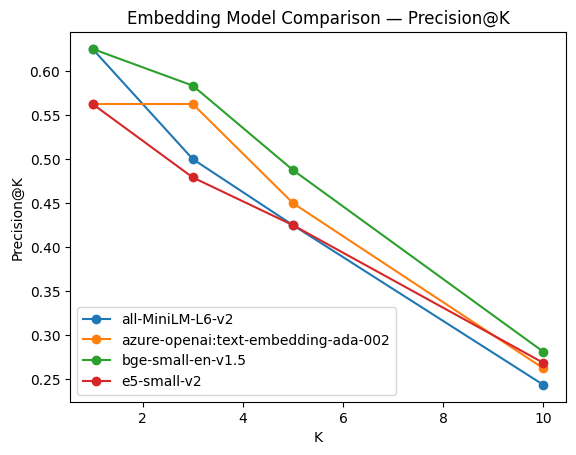

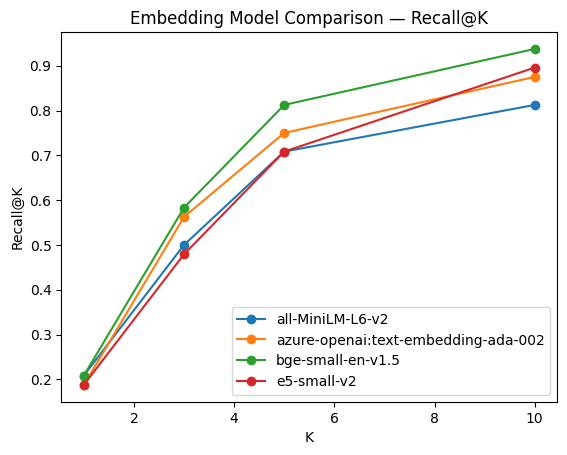

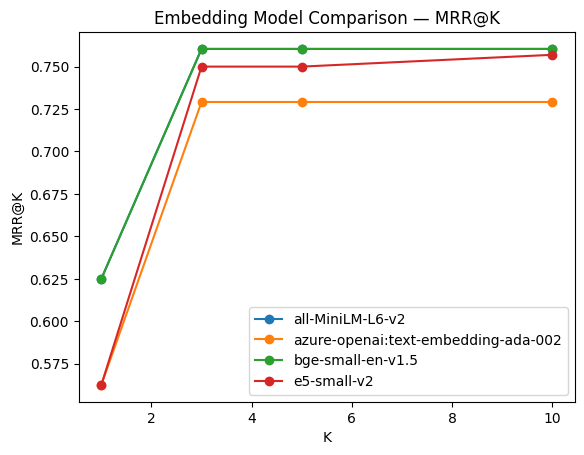

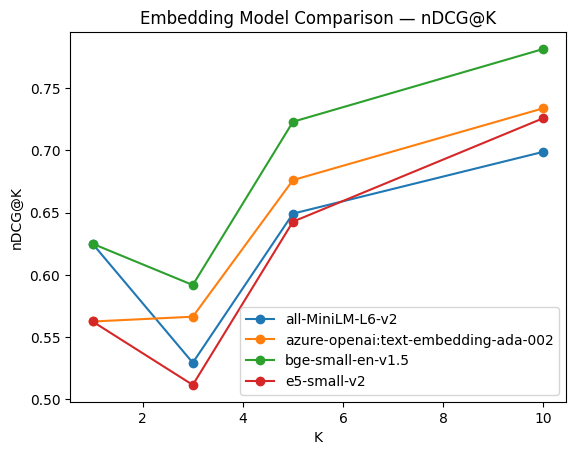

In [11]:

for metric in ["Precision@K", "Recall@K", "MRR@K", "nDCG@K"]:
    barplot_metric(res_df, metric, f"Embedding Model Comparison — {metric}")



## 7) Qualitative inspection

**Purpose.** Metrics don’t tell the whole story; examine actual neighbors for a few queries.

### Code cell: Print Top-5 docs for selected queries

**What it does.**

* For `qid` in `[0, 1, 3, 8]`, prints each model’s **Top-5** with topic labels.
* Helps you spot **off-topic** or **near-miss** results.

**What to look for.**

* Are “tech” queries dominated by “tech” docs?
* Do some models retrieve overly general items (e.g., study tips for a tech query)?
* Are the **first hits** sensible (ties back to MRR)?


In [12]:

inspect_qids = [0, 1, 3, 8]
for qid in inspect_qids:
    print("\n==== Query", qid, "====")
    print("Q:", q_df.loc[qid, "query"])
    for name in rankings_by_model:
        top5 = rankings_by_model[name][qid][:5]
        print(f"\nModel: {name}")
        for rank, did in enumerate(top5, start=1):
            row = doc_df.iloc[did]
            print(f"  {rank:>2}. [doc {did}] ({row['topic']}): {row['text']}")



==== Query 0 ====
Q: How do vector databases help with semantic search?

Model: all-MiniLM-L6-v2
   1. [doc 1] (tech): Vector databases store embeddings for semantic search.
   2. [doc 26] (education): Active recall improves memory and understanding.
   3. [doc 10] (finance): Index funds provide diversified exposure to the market.
   4. [doc 25] (education): Spaced repetition helps retain information long-term.
   5. [doc 16] (travel): How to find cheap flights and flexible fares.

Model: e5-small-v2
   1. [doc 1] (tech): Vector databases store embeddings for semantic search.
   2. [doc 3] (tech): GPU acceleration speeds up deep learning training.
   3. [doc 26] (education): Active recall improves memory and understanding.
   4. [doc 25] (education): Spaced repetition helps retain information long-term.
   5. [doc 7] (health): Sleep quality impacts focus, memory, and recovery.

Model: bge-small-en-v1.5
   1. [doc 1] (tech): Vector databases store embeddings for semantic search.
   2. 



## 8) Stretch — simple score fusion

**Purpose.** Ensemble two models by averaging normalized similarity rows to see if quality nudges upward.

**Design.**

* Recompute similarity matrices `S1`, `S2` for two chosen models.
* **Row-wise min–max normalize** each similarity row (per query) to [0,1].
  (Prevents one model’s score scale from dominating.)
* Average: `S_fused = 0.5 * S1' + 0.5 * S2'`.
* Rank and evaluate as usual.

### Code cell: `sims_for`, fusion computation

**What it does.**

* Builds `S1` (MiniLM) and `S2` (BGE), normalizes per query, averages, and ranks.
* Evaluates with the same `evaluate_retrieval`.

**Why it matters.** Cheap, often effective baseline before moving to learned fusion.

**Caveat.** On tiny corpora, changes can be subtle; on larger corpora, fusion tends to stabilize early-rank variance.




In [13]:
def sims_for(cfg):
    D, Q, _ = encode_model(cfg, list(doc_df["text"].values), list(q_df["query"].values))
    return (Q @ D.T)

cfg1 = next(c for c in models_cfg if c["name"] == "all-MiniLM-L6-v2")
cfg2 = next(c for c in models_cfg if c["name"] == "bge-small-en-v1.5")

S1 = sims_for(cfg1)
S2 = sims_for(cfg2)

def minmax_rowwise(M):
    Mmin = M.min(axis=1, keepdims=True)
    Mmax = M.max(axis=1, keepdims=True)
    return (M - Mmin) / (Mmax - Mmin + 1e-12)

S_fused = 0.5 * minmax_rowwise(S1) + 0.5 * minmax_rowwise(S2)
ranks_fused = {qi: np.argsort(-S_fused[qi]).tolist() for qi in range(S_fused.shape[0])}

df_fused = evaluate_retrieval(gt, ranks_fused, ks=[1,3,5,10])
df_fused["Model"] = "Fusion(MiniLM+BGE)"
res_plus = pd.concat([res_df, df_fused], ignore_index=True)




Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


### Plot Fusion vs Singles

**What it does.**

* Adds a “Fusion(MiniLM+BGE)” line to the charts for a quick visual comparison.

**What to expect.**

* Sometimes fusion helps **nDCG@10** (overall ordering) more than **MRR@1** (first hit).



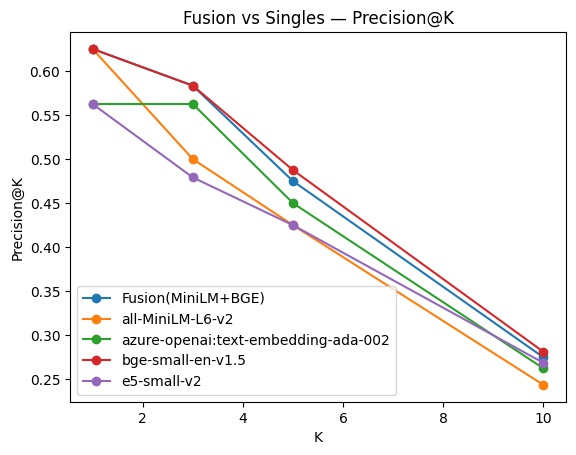

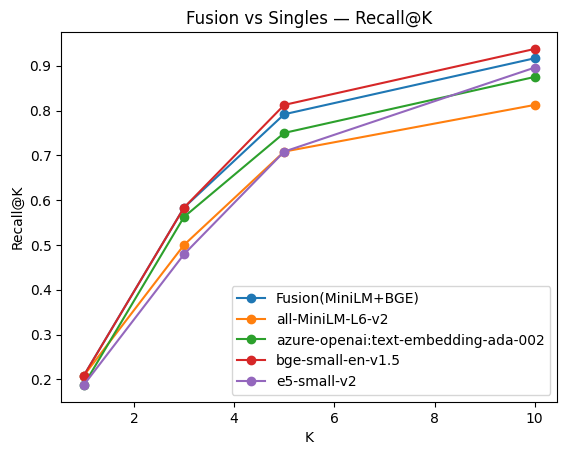

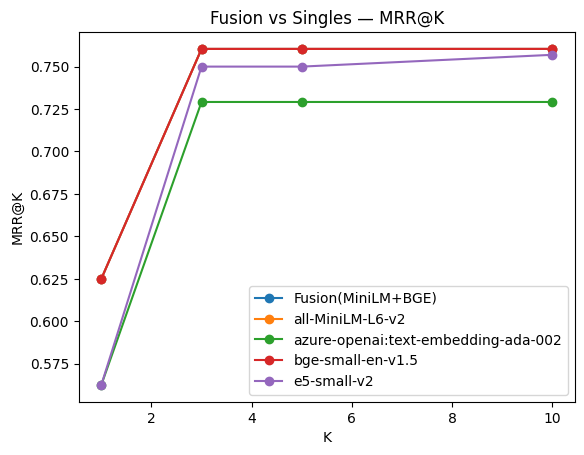

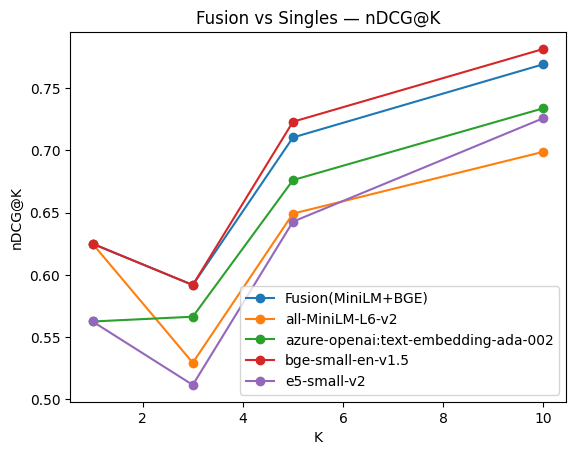

In [14]:

for metric in ["Precision@K", "Recall@K", "MRR@K", "nDCG@K"]:
    barplot_metric(res_plus, metric, f"Fusion vs Singles — {metric}")


## 9) Timing — encode seconds per model

**Purpose.** Tie quality to **cost/latency** considerations.

### Code cell: Build `timing_df`

**What it does.**

* Collects total **encoding time** per model (docs + queries).
* Sorts so fastest is first.

**Why it matters.** In production, you trade off **speed vs quality**. Smaller models often embed much faster.

In [15]:

timing_df = pd.DataFrame([{"Model": k, "Encode_seconds": v} for k, v in timings.items()]).sort_values("Encode_seconds")
timing_df


,Model,Encode_seconds
2,bge-small-en-v1.5,0.080885
1,e5-small-v2,0.082860
0,all-MiniLM-L6-v2,0.684921
3,azure-openai:text-embedding-ada-002,1.396409


### Plot timing

**What it does.**

* Bar chart of encoding seconds per model.

**Interpreting.**

* Use this with metric plots to choose a sweet spot for your use case (e.g., batch processing vs real-time search).

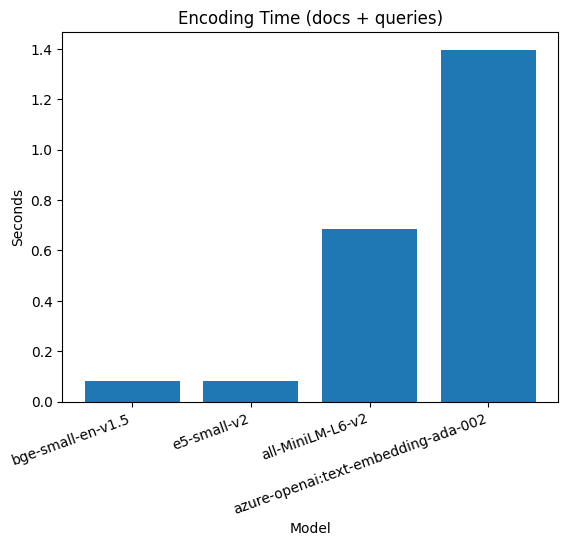

In [16]:

plt.figure()
plt.bar(timing_df["Model"], timing_df["Encode_seconds"])
plt.title("Encoding Time (docs + queries)")
plt.xlabel("Model")
plt.ylabel("Seconds")
plt.xticks(rotation=20, ha="right")
plt.show()



## 10. Summary & reflection
- **Cosine similarity + normalized embeddings** is a strong default across diverse models.
- **Prefixes** matter (e.g., `query:` / `passage:`) — treat model families fairly.
- Compare a **suite** of metrics, not just one; pair with **qualitative** checks.
- **Fusion** can help; try lexical (BM25) + dense as a next step.

**Stretch ideas**
- Add a BM25 baseline and **hybrid fusion** (lexical + dense).  
- Try a larger model (e.g., `all-mpnet-base-v2`) and compare time/quality.  
- Use **FAISS** for approximate nearest neighbors on bigger corpora.  
- Add **graded relevance** and compute nDCG with gains > 1.
